DATA PREPARATION

In [22]:
import pandas as pd
import numpy as np

In [33]:
samples = pd.read_csv("HYP_data\sample_ids(3).txt", header=None, names=["sample_id"])

#Creating 50% labels
n = len(samples)
labels = np.array([1]*int(n/2) + [0]*int(n/2))
np.random.shuffle(labels)

samples["label"] = labels
samples.to_csv("HYP_data\phenotype_HYP_simulated_50_50.tsv", sep='\t', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2601292131.py:1: SyntaxWarning: invalid escape sequence '\s'
  samples = pd.read_csv("HYP_data\sample_ids(3).txt", header=None, names=["sample_id"])
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2601292131.py:9: SyntaxWarning: invalid escape sequence '\p'
  samples.to_csv("HYP_data\phenotype_HYP_simulated_50_50.tsv", sep='\t', index=False)


In [34]:
#Loading samples from VCF
with open("HYP_data\sample_ids(3).txt") as f:
    sample_ids = [line.strip() for line in f]

#Loading raw genotype file (no header)
df = pd.read_csv("HYP_data\Final_hyp_chr_genotypes_raw.txt", sep='\t', header=None)

#Generating column names, followed by sample_ids
column_names = ["CHROM", "POS"] + sample_ids
df.columns = column_names

df.to_csv("HYP_data\HYP_chr_genotypes_with_header.tsv", sep='\t', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\F'
<>:12: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\F'
<>:12: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2210572903.py:2: SyntaxWarning: invalid escape sequence '\s'
  with open("HYP_data\sample_ids(3).txt") as f:
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2210572903.py:6: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("HYP_data\Final_hyp_chr_genotypes_raw.txt", sep='\t', header=None)
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2210572903.py:12: SyntaxWarning: invalid escape sequence '\H'
  df.to_csv("HYP_data\HYP_chr_genotypes_with_header.tsv", sep='\t', index=False)


In [36]:
#Load raw data
raw = pd.read_csv("HYP_data\HYP_chr_genotypes_with_header.tsv", sep='\t')

with open ("HYP_data\sample_ids(3).txt") as f:
    sample_ids = [line.strip() for line in f]

#Extract SNP info and genotypes
snp_ids = raw.iloc[:, 0].astype(str) + "_" +raw.iloc[:, 1].astype(str)
genotypes = raw.iloc[:, 2:]

#Convert GT to dosage (int)
def gt_to_dosage(gt):
    if gt == "0|0":
        return 0
    elif gt in ["0|1", "1|0"]:
        return 1
    elif gt == "1|1":
        return 2
    else:
        return np.nan #handles ./. or missing values
    
#Apply conversion to each cell
dosage_matrix = genotypes.applymap(gt_to_dosage)

#Transpose: rows = samples
X = dosage_matrix.T
X.columns = snp_ids
X.index = sample_ids

X_filled = X.fillna(X.mean())

X_filled.to_csv("HYP_data\HYP_chr_dosage_matrix.csv")

<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2885795849.py:2: SyntaxWarning: invalid escape sequence '\H'
  raw = pd.read_csv("HYP_data\HYP_chr_genotypes_with_header.tsv", sep='\t')
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2885795849.py:4: SyntaxWarning: invalid escape sequence '\s'
  with open ("HYP_data\sample_ids(3).txt") as f:
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2885795849.py:32: SyntaxWarning: invalid escape sequence '\H'
  X_filled.to_csv("HYP_data\HYP_chr_dosage_matrix.csv")
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2885795849.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dosage_matr

In [37]:
#Creating phenotype file from dosage matrix
X = pd.read_csv("HYP_data\HYP_chr_dosage_matrix.csv", index_col=0)
y = pd.read_csv("HYP_data\phenotype_HYP_simulated_50_50.tsv", sep='\t')

y_matched = y[y["sample_id"].isin(X.index)].copy()
X_aligned = X.loc[y_matched["sample_id"]]

assert all(X_aligned.index == y_matched["sample_id"]), "Sample alignment mismatch!"

#Preview of file
print("Matrix shape:", X_aligned.shape)
print("Phenotype breakdown:\n", y_matched["label"].value_counts())
y_matched.to_csv("HYP_data\phenotype_HYP_aligned.csv", index=False)
y_matched.head()

Matrix shape: (2504, 13)
Phenotype breakdown:
 label
0    1252
1    1252
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\907285222.py:2: SyntaxWarning: invalid escape sequence '\H'
  X = pd.read_csv("HYP_data\HYP_chr_dosage_matrix.csv", index_col=0)
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\907285222.py:3: SyntaxWarning: invalid escape sequence '\p'
  y = pd.read_csv("HYP_data\phenotype_HYP_simulated_50_50.tsv", sep='\t')
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\907285222.py:13: SyntaxWarning: invalid escape sequence '\p'
  y_matched.to_csv("HYP_data\phenotype_HYP_aligned.csv", index=False)


,sample_id,label
0,HG00096,0
1,HG00097,0
2,HG00099,0
3,HG00100,0
4,HG00101,1


In [38]:
#Creating Final files for genotype and phenotype
pheno = pd.read_csv("HYP_data\phenotype_HYP_aligned.csv", sep=',')
dosage_matrix = pd.read_csv("HYP_data\HYP_chr_dosage_matrix.csv", index_col=0)

#Converting labels to integers (0=control, 1=case)
pheno["label"] = pheno["label"].astype(int)

#Aligning samples between phenotype and genotype data and getting the intersection of Sample IDs
common_samples= list(set(pheno["sample_id"]).intersection(dosage_matrix.index))

#Filter both datasets
pheno_aligned = pheno[pheno["sample_id"].isin(common_samples)].set_index("sample_id")
dosage_aligned = dosage_matrix.loc[common_samples]

#Checking alignment
print(f"\nOriginal samples: Pheno={len(pheno)}, Geno={len(dosage_matrix)}")
print(f"Aligned samples: {len(common_samples)}")
print(f"\nPhenotype distribution:")
print(pheno_aligned["label"].value_counts())

#Prepare X and Y for model training
X = dosage_aligned.astype(float)
y = pheno_aligned["label"].values

#Saving the aligned datasets
pheno_aligned.to_csv("HYP_data\HYP_aligned_phenotypes_final.csv")
X.to_csv("HYP_data\HYP_aligned_genotypes_final.csv")
pheno_aligned.head()


Original samples: Pheno=2504, Geno=2504
Aligned samples: 2504

Phenotype distribution:
label
0    1252
1    1252
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\H'
<>:26: SyntaxWarning: invalid escape sequence '\H'
<>:27: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\H'
<>:26: SyntaxWarning: invalid escape sequence '\H'
<>:27: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2049344695.py:2: SyntaxWarning: invalid escape sequence '\p'
  pheno = pd.read_csv("HYP_data\phenotype_HYP_aligned.csv", sep=',')
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2049344695.py:3: SyntaxWarning: invalid escape sequence '\H'
  dosage_matrix = pd.read_csv("HYP_data\HYP_chr_dosage_matrix.csv", index_col=0)
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2049344695.py:26: SyntaxWarning: invalid escape sequence '\H'
  pheno_aligned.to_csv("HYP_data\HYP_aligned_phenotypes_final.csv")
C:\Users\Sanjib Das\AppData\L

,label
sample_id,
HG00096,0
HG00097,0
HG00099,0
HG00100,0
HG00101,1


In [39]:
#Removing unnamed column in genotypes file
df = pd.read_csv("HYP_data\HYP_aligned_genotypes_final.csv")

#Fix the index column
if 'Unnamed: 0' in df.columns:
    df = df.set_index('Unnamed: 0')
    df.index.name = None  

#Verify
print("Fixed DataFrame:")
print(df.head(1))

#Saving corrected file (overwrite original)
df.to_csv("HYP_data\HYP_aligned_genotypes_final.csv", index=True)  # index=True preserves sample IDs as column

print("\nFiles saved without duplicate index column!")

Fixed DataFrame:
         1_19626393  1_30966129  1_62114132  5_61160000  5_135947363  \
NA20538         0.0         1.0         0.0         0.0          0.0   

         6_33080689  7_34078932  10_19450323  11_418745  11_26643241  \
NA20538         0.0         0.0          0.0        0.0          0.0   

         11_126345344  17_21300910  19_16878582  
NA20538           0.0          0.0          0.0  

Files saved without duplicate index column!


<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:14: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:14: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\3199308337.py:2: SyntaxWarning: invalid escape sequence '\H'
  df = pd.read_csv("HYP_data\HYP_aligned_genotypes_final.csv")
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\3199308337.py:14: SyntaxWarning: invalid escape sequence '\H'
  df.to_csv("HYP_data\HYP_aligned_genotypes_final.csv", index=True)  # index=True preserves sample IDs as column


In [40]:
# Removing unnamed column in phenotype file
df = pd.read_csv("HYP_data\HYP_aligned_phenotypes_final.csv")

# Fixing the index column
if 'Unnamed: 0' in df.columns:
    df = df.set_index('Unnamed: 0')
    df.index.name = None  

# Verify
print("Fixed DataFrame:")
print(df.head())

# Saving corrected file (overwrite original)
df.to_csv("HYP_data\HYP_aligned_phenotypes_final.csv", index=False)  # index=True preserves sample IDs as column

print("\nFile saved without duplicate index column!")

Fixed DataFrame:
  sample_id  label
0   HG00096      0
1   HG00097      0
2   HG00099      0
3   HG00100      0
4   HG00101      1

File saved without duplicate index column!


<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:14: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:14: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\3823472495.py:2: SyntaxWarning: invalid escape sequence '\H'
  df = pd.read_csv("HYP_data\HYP_aligned_phenotypes_final.csv")
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\3823472495.py:14: SyntaxWarning: invalid escape sequence '\H'
  df.to_csv("HYP_data\HYP_aligned_phenotypes_final.csv", index=False)  # index=True preserves sample IDs as column


In [41]:
# Final Verification of all files 

genotypes = pd.read_csv("HYP_data\HYP_aligned_genotypes_final.csv", index_col=0)
phenotypes = pd.read_csv("HYP_data\HYP_aligned_phenotypes_final.csv")

# Basic phenotype checks
print("=== Phenotype Data Validation ===")
print(f"Total samples: {len(phenotypes)}")
print("\nFirst 5 rows:")
print(phenotypes.head())

print("\nLabel distribution:")
print(phenotypes['label'].value_counts())

# Checking for common issues
print("\n=== Quality Checks ===")
print(f"Missing labels: {phenotypes['label'].isna().sum()}")
print(f"Duplicate sample IDs: {phenotypes['sample_id'].duplicated().sum()}")
print(f"Non-binary labels: {set(phenotypes['label']) - {0, 1}}")  # Should be empty set

# Verifying alignment with genotypes
common_samples = set(phenotypes['sample_id']).intersection(genotypes.index)
print(f"\nSamples in both files: {len(common_samples)}/{len(phenotypes)}")

mismatched = set(phenotypes['sample_id']).symmetric_difference(genotypes.index)
if mismatched:
    print("\nWarning: Mismatched sample IDs (first 5):")
    print(list(mismatched)[:5])
else:
    print("\nAll sample IDs match perfectly!")

if len(mismatched) > 0:
    print("\nCleaning sample IDs...")
    phenotypes['sample_id'] = phenotypes['sample_id'].str.strip().str.upper()
    genotypes.index = genotypes.index.str.strip().str.upper()
    
    common_samples = set(phenotypes['sample_id']).intersection(genotypes.index)
    phenotypes = phenotypes[phenotypes['sample_id'].isin(common_samples)]
    genotypes = genotypes.loc[common_samples]
    
    print(f"Final aligned samples: {len(common_samples)}")
    
    phenotypes.to_csv("HYP_data\HYP_aligned_phenotypes_cleaned.csv", index=False)
    genotypes.to_csv("HYP_data\HYP_aligned_genotypes_cleaned.csv", index=True)
    print("Saved cleaned files!")

=== Phenotype Data Validation ===
Total samples: 2504

First 5 rows:
  sample_id  label
0   HG00096      0
1   HG00097      0
2   HG00099      0
3   HG00100      0
4   HG00101      1

Label distribution:
label
0    1252
1    1252
Name: count, dtype: int64

=== Quality Checks ===
Missing labels: 0
Duplicate sample IDs: 0
Non-binary labels: set()

Samples in both files: 2504/2504

All sample IDs match perfectly!


<>:3: SyntaxWarning: invalid escape sequence '\H'
<>:4: SyntaxWarning: invalid escape sequence '\H'
<>:43: SyntaxWarning: invalid escape sequence '\H'
<>:44: SyntaxWarning: invalid escape sequence '\H'
<>:3: SyntaxWarning: invalid escape sequence '\H'
<>:4: SyntaxWarning: invalid escape sequence '\H'
<>:43: SyntaxWarning: invalid escape sequence '\H'
<>:44: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2487392432.py:3: SyntaxWarning: invalid escape sequence '\H'
  genotypes = pd.read_csv("HYP_data\HYP_aligned_genotypes_final.csv", index_col=0)
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2487392432.py:4: SyntaxWarning: invalid escape sequence '\H'
  phenotypes = pd.read_csv("HYP_data\HYP_aligned_phenotypes_final.csv")
C:\Users\Sanjib Das\AppData\Local\Temp\ipykernel_17724\2487392432.py:43: SyntaxWarning: invalid escape sequence '\H'
  phenotypes.to_csv("HYP_data\HYP_aligned_phenotypes_cleaned.csv", index=False)
C:\Users\San

MODEL TRAINING AND TESTING

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import os

In [2]:
# File path

result_dir = os.path.join('..', 'Outputs', 'HYP_results')
target_dir = os.path.join('..', 'Final Datasets', 'HYP_final')
raw_file_dir = os.path.join('..', 'Raw_Datasets', 'HYP_data')

# Final File path 
snp_file = os.path.join(raw_file_dir, 'HyperTH_top2000_cleaned.csv')
pheno_final_extended = os.path.join(target_dir, 'HYP_aligned_phenotypes_final_extended.csv')
pheno_final_path = os.path.join(target_dir, 'HYP_aligned_phenotypes_final.csv') 
geno_final_path = os.path.join(target_dir, 'HYP_aligned_genotypes_final.csv')
logreg_model = os.path.join(result_dir, 'HYP_selectKbest_logreg_model.joblib')
logreg_coeff = os.path.join(result_dir, 'logreg_selectKbest_coefficients.csv')
logreg_model_AS = os.path.join(result_dir, 'HYP_selectKbest_logreg_model_AgeSex.joblib')
logreg_coeff_AS = os.path.join(result_dir, 'logreg_selectKbest_coefficients_AgeSex.csv')
model_perf = os.path.join(result_dir, 'HYP_selectKbest_model_performance.png')
model_perf_AS = os.path.join(result_dir, 'HYP_selectKbest_model_performance_AgeSex.png')
cf_matrix = os.path.join(result_dir, 'HYP_confusion_matrix.png')
prs_csv = os.path.join(result_dir, 'HYP_prs_scores.csv')
prs_png = os.path.join(result_dir, 'HYP_PRS_distribution_fixed.png')

In [3]:
# Loading the data
X = pd.read_csv(geno_final_path, index_col=0)
y = pd.read_csv(pheno_final_path).set_index("sample_id")["label"]

#Aligning the samples
common = X.index.intersection(y.index)
X = X.loc[common]
y = y.loc[common]

selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(X, y)
selected_snps = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=selected_snps)


C:\Users\Sanjib Das\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=100 is greater than n_features=13. All the features will be returned.
  warnings.warn(


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.10, stratify=y, random_state=42
)

In [5]:
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=np.logspace(-4,1,20),
    cv=10,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.528
Test AUC: 0.533

Accuracy (threshold 0.5): 0.514

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.40      0.45       126
           1       0.51      0.63      0.56       125

    accuracy                           0.51       251
   macro avg       0.52      0.51      0.51       251
weighted avg       0.52      0.51      0.51       251



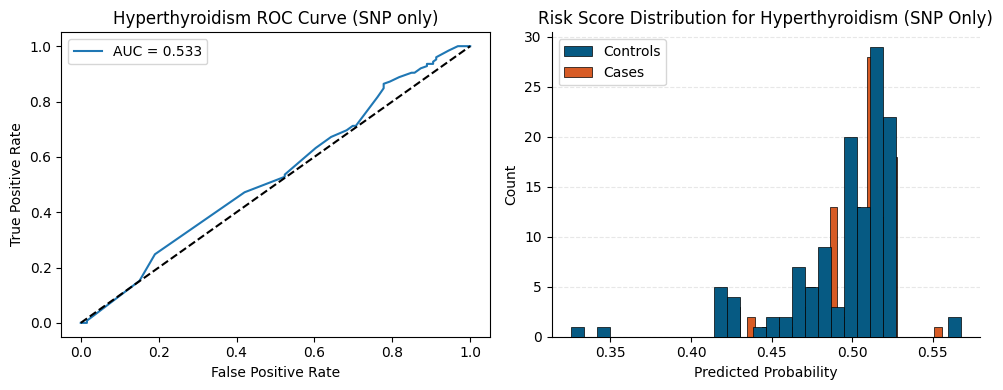


Confusion Matrix (threshold = 0.5):
[[50 76]
 [46 79]]


In [6]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Hyperthyroidism ROC Curve (SNP only)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=3)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=2)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for Hyperthyroidism (SNP Only)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))

In [7]:
#Taking only Age And Sex

# 1. Load phenotypes (has age, sex, label)
df = pd.read_csv(pheno_final_extended).set_index("sample_id")

# 2. Define age+sex as features, label as target
df["sex"] = df["sex"].map({"M":0, "F":1})
X_age_sex = df[["age", "sex"]]
y = df["label"]

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_age_sex, y, stratify=y, test_size=0.10, random_state=42
)

# 4. Train and Evaluate
model = LogisticRegressionCV(Cs=10, cv=10, penalty='l1', solver='saga', max_iter=10000, n_jobs=2, random_state=42)
model.fit(X_train, y_train)

auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"Age + Sex Only AUC: {auc:.3f}")

Age + Sex Only AUC: 0.500


In [8]:
#Taking sex and age as covariates

X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_extended).set_index("sample_id")

common = X.index.intersection(phenos.index)
X = X.loc[common]
phenos = phenos.loc[common]

phenos["sex_bin"] = phenos["sex"].map({"M":0, "F":1})

y = phenos["label"]
age = phenos["age"]
sex = phenos["sex_bin"]

In [9]:
selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(X, y)
selected_snps = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=selected_snps)

X_selected_df["age"] = age
X_selected_df["sex"] = sex

C:\Users\Sanjib Das\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=100 is greater than n_features=13. All the features will be returned.
  warnings.warn(


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.10, stratify=y, random_state=42
)

In [11]:
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=np.logspace(-4,1,20),
    cv=10,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.529
Test AUC: 0.539

Accuracy (threshold 0.5): 0.534

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.44      0.49       126
           1       0.53      0.62      0.57       125

    accuracy                           0.53       251
   macro avg       0.54      0.53      0.53       251
weighted avg       0.54      0.53      0.53       251



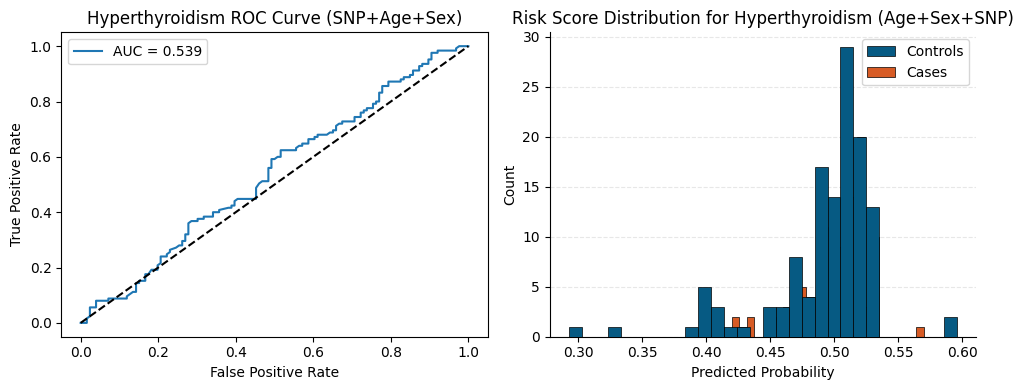


Confusion Matrix (threshold = 0.5):
[[56 70]
 [47 78]]


In [12]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model_AS)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff_AS)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Hyperthyroidism ROC Curve (SNP+Age+Sex)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=3)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=2)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for Hyperthyroidism (Age+Sex+SNP)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf_AS, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))

In [13]:
model = joblib.load(logreg_model)  

# Best C chosen by CV
C_star = model.C_[0]               
lambda_star = 1 / C_star           

print(f"Best C (C*): {C_star}")
print(f"Regularization Strength λ* = {lambda_star:.4e}")

Best C (C*): 0.4832930238571752
Regularization Strength λ* = 2.0691e+00



SNPs in coefficients file: 13
Overlap in X genotype matrix: 13


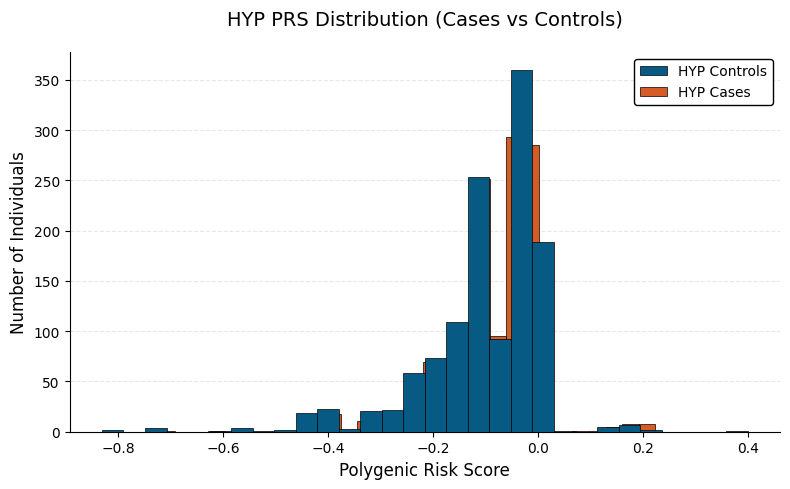

In [14]:
X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_path).set_index("sample_id")

model = joblib.load(logreg_model)
coef = pd.read_csv(logreg_coeff, index_col=0)
coef = coef.squeeze()

selected_snps = coef.index.tolist()
X_prs = X[selected_snps]

prs_scores = X_prs.dot(coef)
prs_df = phenos[["label"]].copy()
prs_df["PRS"] = prs_scores

print("\nSNPs in coefficients file:", len(selected_snps))
print("Overlap in X genotype matrix:", X.columns.intersection(selected_snps).shape[0])

prs_df.to_csv(prs_csv)


#Histogram plotting
case_color = "#d75b25"      
control_color = "#065a83"    

plt.figure(figsize=(8, 5), dpi=100)

plt.hist(
    prs_df[prs_df["label"] == 0]["PRS"],
    bins=30,
    alpha=1,
    label="HYP Controls",
    color=control_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=3
)

plt.hist(
    prs_df[prs_df["label"] == 1]["PRS"],
    bins=30,
    alpha=1,
    label="HYP Cases",
    color=case_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)

plt.title("HYP PRS Distribution (Cases vs Controls)", fontsize=14, pad=20)
plt.xlabel("Polygenic Risk Score", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.legend(framealpha=1, edgecolor='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(prs_png, dpi=500, bbox_inches='tight')
plt.show()

In [15]:
# Top 10% threshold taken
prs_threshold = prs_df["PRS"].quantile(0.90)

# Counting individuals above it
high_risk = prs_df[prs_df["PRS"] >= prs_threshold]

# Splitting by label
high_risk_cases = high_risk[high_risk["label"] == 1].shape[0]
high_risk_controls = high_risk[high_risk["label"] == 0].shape[0]

print(f"Top 10% PRS threshold: {prs_threshold:.9f}")
print(f"T2D Cases in top 10%: {high_risk_cases}")
print(f"Controls in top 10%: {high_risk_controls}")

Top 10% PRS threshold: 0.000000000
T2D Cases in top 10%: 227
Controls in top 10%: 205


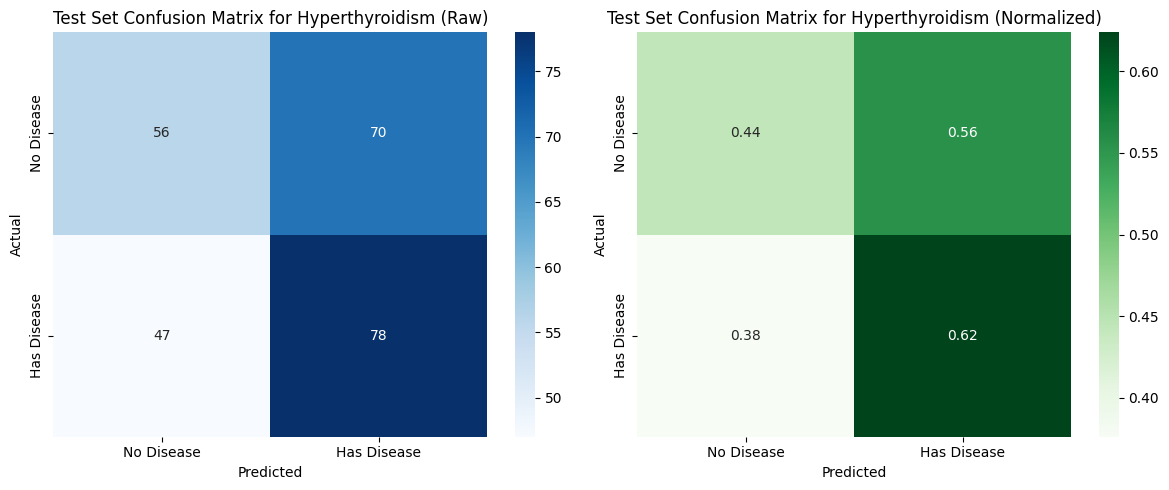

In [16]:
# Predicted labels using threshold 0.5
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix - Raw
cm_raw = confusion_matrix(y_test, y_pred_label)

# Confusion Matrix - Normalized
cm_normalized = confusion_matrix(y_test, y_pred_label, normalize='true')

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw Confusion Matrix
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Test Set Confusion Matrix for Hyperthyroidism (Raw)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Disease', 'Has Disease'])
axes[0].set_yticklabels(['No Disease', 'Has Disease'])

# Normalized Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix for Hyperthyroidism (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Disease', 'Has Disease'])
axes[1].set_yticklabels(['No Disease', 'Has Disease'])

plt.tight_layout()
plt.savefig(cf_matrix, dpi=300)
plt.show()